# Summary of prediction analysis for DE genes

In [1]:
import os, errno
import pandas as pd
import seaborn as sns
from venn import venn
import matplotlib.pyplot as plt

## Functions

In [2]:
def mkdir_p(directory):
    """
    Make a directory if it does not already exist.

    Input: Directory name
    """
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

## Summary of features

In [3]:
degs = pd.read_csv("../../../../_m/degs_annotation.txt", sep='\t', index_col=0)
dtu = pd.read_csv("../../../../../differential_analysis/tissue_comparison/ds_summary/_m/diffSplicing_ancestry_FDR05_4regions.tsv", sep='\t')
dtu.groupby("Tissue").size()

Tissue
Caudate          1901
DLPFC            1345
Dentate Gyrus     655
Hippocampus      1332
dtype: int64

In [4]:
for tissue in ["Caudate", "Dentate Gyrus", "DLPFC", "Hippocampus"]:
    overlap = len(set(degs[(degs["Tissue"] == tissue)].gene_name) & 
                  set(dtu[(dtu["Tissue"] == tissue)].gene))
    print("There are {} overlapping DTU in DEGs for {}!".format(overlap, tissue))

There are 385 overlapping DTU in DEGs for Caudate!
There are 51 overlapping DTU in DEGs for Dentate Gyrus!
There are 251 overlapping DTU in DEGs for DLPFC!
There are 227 overlapping DTU in DEGs for Hippocampus!


## Load and prep summary files

### Load files

In [5]:
rf0 = pd.read_csv("../../rf/summary_10Folds_allTissues.tsv", sep='\t')
enet0 = pd.read_csv("../../enet/summary_10Folds_allTissues.tsv", sep='\t')

### Group, select, and clean summary results

In [6]:
## Extract median of model metrics over 10 folds
rf = rf0.groupby(["tissue", "feature"]).median()\
        .loc[:, ["n_features", "test_score_r2"]].reset_index()
rf.feature = rf.feature.str.replace("_", ".", regex=True)
rf["Model"] = "Random Forest"
enet = enet0.groupby(["tissue", "feature"]).median()\
        .loc[:, ["n_features", "test_score_r2"]].reset_index()
enet.feature = enet.feature.str.replace("_", ".", regex=True)
enet["Model"] = "Elastic Net"

df = pd.concat([rf, enet], axis=0)
df.head(2)

,tissue,feature,n_features,test_score_r2,Model
0,Caudate,ENSG00000003249.13,33.5,0.037818,Random Forest
1,Caudate,ENSG00000003509.15,3.0,-0.063606,Random Forest


### Overlap with DTU

In [7]:
dx = df.merge(degs[["gene_name"]], left_on="feature", right_index=True).drop_duplicates()
for tissue in ["Caudate", "Dentate Gyrus", "DLPFC", "Hippocampus"]:
    overlap = len(set(dx[(dx["tissue"] == tissue)].gene_name) & 
                  set(dtu[(dtu["Tissue"] == tissue)].gene))
    print("There are {} overlapping DTU in DEGs for {}!".format(overlap, tissue))

There are 376 overlapping DTU in DEGs for Caudate!
There are 45 overlapping DTU in DEGs for Dentate Gyrus!
There are 242 overlapping DTU in DEGs for DLPFC!
There are 219 overlapping DTU in DEGs for Hippocampus!


### Add partial r2 results

In [8]:
partial = pd.read_csv("../../partial_r2/rf_partial_r2_metrics.tsv", sep='\t')\
            .rename(columns={"Geneid": "Feature"})
partial.columns = partial.columns.str.lower()
partial["test_score_r2"] = partial.partial_r2
partial["Model"] = "Partial R2"
partial = partial.loc[:, ['tissue', 'feature', 'n_features', 'test_score_r2', 'Model']]
partial.head(2)

,tissue,feature,n_features,test_score_r2,Model
0,Caudate,ENSG00000003249.13,33,0.243673,Partial R2
1,Caudate,ENSG00000003509.15,2,0.013140,Partial R2


In [9]:
df2 = pd.concat([df, partial], axis=0)
df2.groupby(["tissue", "Model"]).size()

tissue         Model        
Caudate        Elastic Net      2929
               Partial R2       2867
               Random Forest    2929
DLPFC          Elastic Net      2711
               Partial R2       2660
               Random Forest    2711
Dentate Gyrus  Elastic Net       773
               Partial R2        770
               Random Forest     773
Hippocampus    Elastic Net      2911
               Partial R2       2843
               Random Forest    2911
dtype: int64

## Summary of results

### Histogram of R2 (median test R2 score)

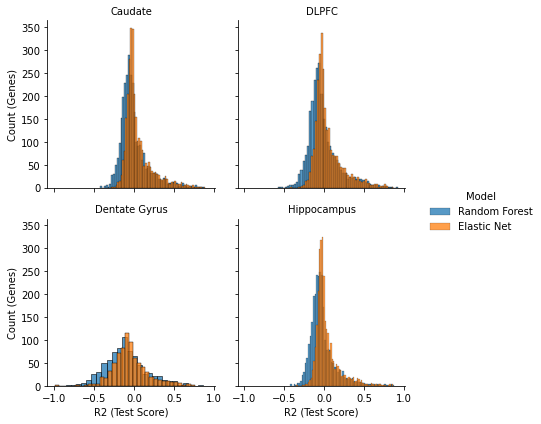

In [5]:
grid = sns.FacetGrid(df, col="tissue", col_wrap=2, hue="Model")
grid.map(sns.histplot, "test_score_r2")
grid.set_axis_labels("R2 (Test Score)", "Count (Genes)")
grid.set_titles(col_template="{col_name}")
grid.add_legend()
grid.tight_layout()
grid.savefig("histogram_test_r2.pdf")
grid.savefig("histogram_test_r2.png")
grid.savefig("histogram_test_r2.svg")

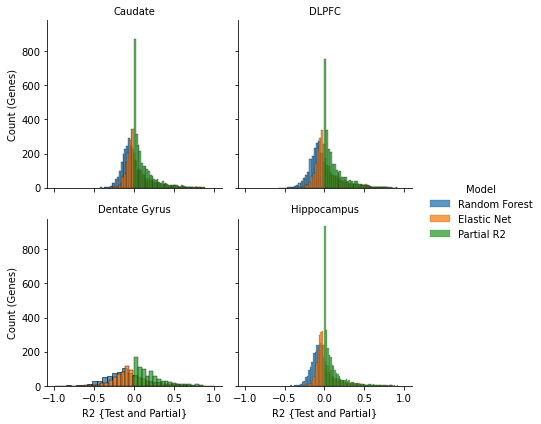

In [20]:
grid = sns.FacetGrid(df2, col="tissue", col_wrap=2, hue="Model")
grid.map(sns.histplot, "test_score_r2")
grid.set_axis_labels("R2 {Test and Partial}", "Count (Genes)")
grid.set_titles(col_template="{col_name}")
grid.add_legend()
grid.tight_layout()
grid.savefig("histogram_test_N_partial_r2.pdf")
grid.savefig("histogram_test_N_partial_r2.png")
grid.savefig("histogram_test_N_partial_r2.svg")

### What number of DEGs do not have any SNPs within 20 Kbp of gene body?

In [10]:
for tissue in ["Caudate", "DLPFC", "Hippocampus", "Dentate Gyrus"]:
    xx = set(df[(df["tissue"] == tissue)].feature)
    yy = set(degs[(degs["Tissue"] == tissue)].index)
    txt = "{} of {} ({:.1%}) of DE genes do not have SNPs within 20Kbp."
    print(txt.format(len(yy) - len(xx), len(yy), (len(yy) - len(xx)) / len(yy)))

41 of 2970 (1.4%) of DE genes do not have SNPs within 20Kbp.
49 of 2760 (1.8%) of DE genes do not have SNPs within 20Kbp.
45 of 2956 (1.5%) of DE genes do not have SNPs within 20Kbp.
13 of 786 (1.7%) of DE genes do not have SNPs within 20Kbp.


### Number of ancestry DE genes expression that can be predictive with SNP

In [11]:
df[(df["test_score_r2"] >= 0.5)].groupby(["tissue", "Model"]).size()

tissue         Model        
Caudate        Elastic Net      92
               Random Forest    74
DLPFC          Elastic Net      92
               Random Forest    69
Dentate Gyrus  Elastic Net      20
               Random Forest    14
Hippocampus    Elastic Net      56
               Random Forest    52
dtype: int64

In [12]:
df[(df["test_score_r2"] >= 0.75)].groupby(["tissue", "Model"]).size()

tissue         Model        
Caudate        Elastic Net      11
               Random Forest    11
DLPFC          Elastic Net      11
               Random Forest     7
Dentate Gyrus  Elastic Net       1
               Random Forest     1
Hippocampus    Elastic Net      12
               Random Forest    13
dtype: int64

In [13]:
print(df[(df["test_score_r2"] >= 0.85)].groupby(["tissue", "Model"]).size().reset_index())
df[(df["test_score_r2"] >= 0.85)]

          tissue          Model  0
0        Caudate    Elastic Net  2
1        Caudate  Random Forest  1
2          DLPFC    Elastic Net  1
3          DLPFC  Random Forest  2
4  Dentate Gyrus  Random Forest  1
5    Hippocampus    Elastic Net  2
6    Hippocampus  Random Forest  1


,tissue,feature,n_features,test_score_r2,Model
34,Caudate,ENSG00000013573.16,28.5,0.875303,Random Forest
4219,DLPFC,ENSG00000166435.15,57.5,0.851186,Random Forest
4936,DLPFC,ENSG00000226278.1,16.0,0.919475,Random Forest
6205,Dentate Gyrus,ENSG00000226278.1,10.5,0.860346,Random Forest
7765,Hippocampus,ENSG00000166435.15,15.0,0.871976,Random Forest
34,Caudate,ENSG00000013573.16,36.0,0.890378,Elastic Net
1313,Caudate,ENSG00000166435.15,20.5,0.878129,Elastic Net
4219,DLPFC,ENSG00000166435.15,19.5,0.864944,Elastic Net
7765,Hippocampus,ENSG00000166435.15,19.5,0.863666,Elastic Net
8952,Hippocampus,ENSG00000256274.1,26.0,0.861908,Elastic Net


In [14]:
set(df[(df["test_score_r2"] >= 0.85)].feature)

{'ENSG00000013573.16',
 'ENSG00000166435.15',
 'ENSG00000226278.1',
 'ENSG00000256274.1'}

- **ENSG00000166435.15** is *XRRA1* one of the most significant eQTLs in the brain
- **ENSG00000013573.16** is *DDX11*
- **ENSG00000226278.1** is *PSPHP1* a pseudogene
- **ENSG00000256274.1** is *TAS2R64P* anohter pseudogene

In [15]:
print(df[(df["test_score_r2"] >= 0.9)].groupby(["tissue", "Model"]).size().reset_index())
df[(df["test_score_r2"] >= 0.9)]

  tissue          Model  0
0  DLPFC  Random Forest  1


,tissue,feature,n_features,test_score_r2,Model
4936,DLPFC,ENSG00000226278.1,16.0,0.919475,Random Forest


### Overlapping with DTU

In [16]:
df3 = dx.merge(dtu, left_on=["gene_name", "tissue"], right_on=["gene", "Tissue"])
df3[(df3["test_score_r2"] >= 0.5)].groupby(["Tissue", "Model"]).size()

Tissue         Model        
Caudate        Elastic Net      18
               Random Forest    15
DLPFC          Elastic Net      20
               Random Forest    13
Dentate Gyrus  Elastic Net       1
               Random Forest     1
Hippocampus    Elastic Net      10
               Random Forest     8
dtype: int64

In [19]:
df3[(df3["test_score_r2"] >= 0.75)].groupby(["Tissue", "Model"]).size()

Tissue  Model        
DLPFC   Elastic Net      3
        Random Forest    1
dtype: int64

In [20]:
df3[(df3["test_score_r2"] >= 0.75)]

,tissue,feature,n_features,test_score_r2,Model,gene_name,clusterID,N,coord,gene,annotation,FDR,chr,Type,Tissue
91,DLPFC,ENSG00000074803.17,20.5,0.774869,Elastic Net,SLC12A1,clu_134504_+,14,chr15:48178400-48220634,SLC12A1,cryptic,9.440000e-07,chr15,DTU,DLPFC
842,DLPFC,ENSG00000166435.15,57.5,0.851186,Random Forest,XRRA1,clu_6194_-,14,chr11:74848462-74907145,XRRA1,cryptic,4.430000e-05,chr11,DTU,DLPFC
843,DLPFC,ENSG00000166435.15,19.5,0.864944,Elastic Net,XRRA1,clu_6194_-,14,chr11:74848462-74907145,XRRA1,cryptic,4.430000e-05,chr11,DTU,DLPFC
1477,DLPFC,ENSG00000257218.5,16.0,0.778071,Elastic Net,GATC,clu_47435_+,3,chr12:120446829-120457076,GATC,annotated,2.330000e-02,chr12,DTU,DLPFC


### What is the overlap between models?

In [11]:
for tissue in ["Caudate", "DLPFC", "Hippocampus", "Dentate Gyrus"]:
    print(tissue)
    for r2 in [0, 0.2, 0.5, 0.6, 0.7, 0.75, 0.8, 0.825]:
        ee = enet[(enet["tissue"] == tissue) & (enet["test_score_r2"] >= r2)].copy()
        rr = rf[(rf["tissue"] == tissue) & (rf["test_score_r2"] >= r2)].copy()
        oo = len(set(ee.feature) & set(rr.feature))
        txt = "There is {} out of {} and {} genes overlapping between enet and rf - at R2 > {}"
        print(txt.format(oo, len(set(ee.feature)), len(set(rr.feature)), r2))
    print("")

Caudate
There is 925 out of 1343 and 1002 genes overlapping between enet and rf - at R2 > 0
There is 320 out of 434 and 345 genes overlapping between enet and rf - at R2 > 0.2
There is 72 out of 92 and 74 genes overlapping between enet and rf - at R2 > 0.5
There is 36 out of 43 and 39 genes overlapping between enet and rf - at R2 > 0.6
There is 17 out of 18 and 19 genes overlapping between enet and rf - at R2 > 0.7
There is 9 out of 11 and 11 genes overlapping between enet and rf - at R2 > 0.75
There is 5 out of 6 and 6 genes overlapping between enet and rf - at R2 > 0.8
There is 2 out of 3 and 4 genes overlapping between enet and rf - at R2 > 0.825

DLPFC
There is 856 out of 1216 and 936 genes overlapping between enet and rf - at R2 > 0
There is 311 out of 414 and 330 genes overlapping between enet and rf - at R2 > 0.2
There is 63 out of 92 and 69 genes overlapping between enet and rf - at R2 > 0.5
There is 28 out of 41 and 30 genes overlapping between enet and rf - at R2 > 0.6
There 

/home/jbenja13/.local/lib/python3.9/site-packages/venn/_venn.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = subplots(nrows=1, ncols=1, figsize=figsize)


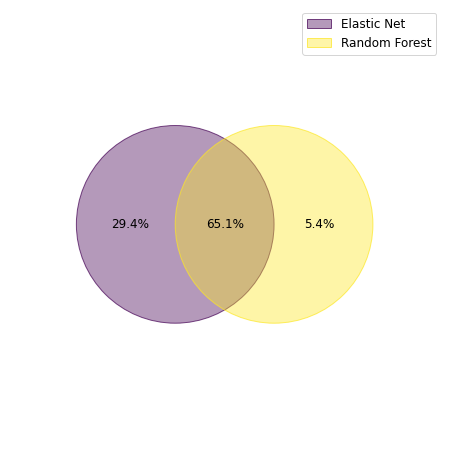

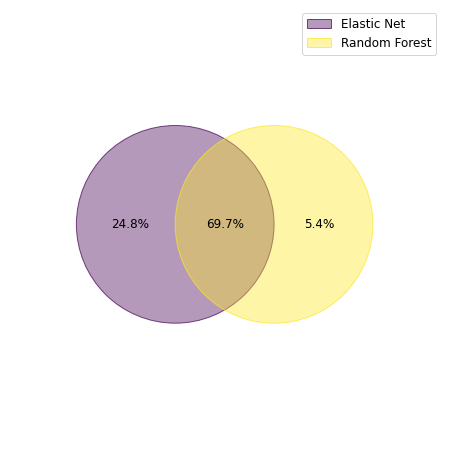

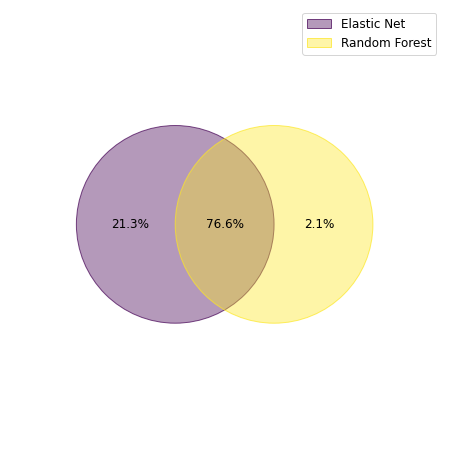

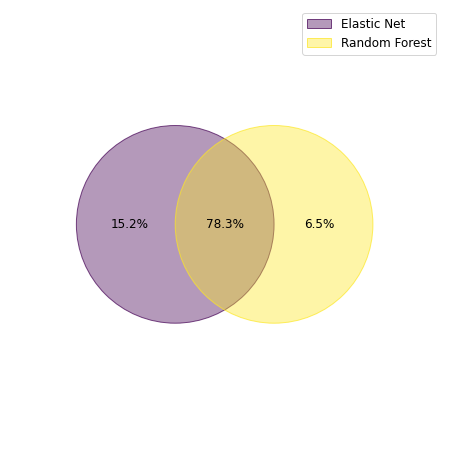

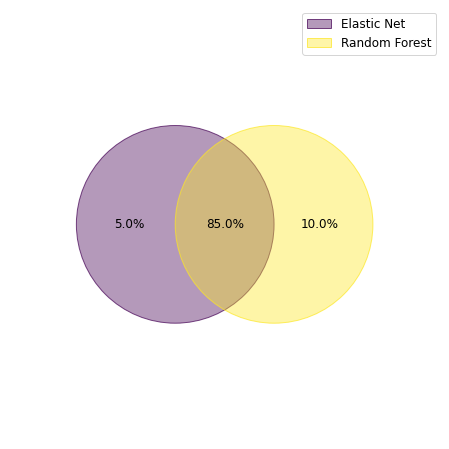

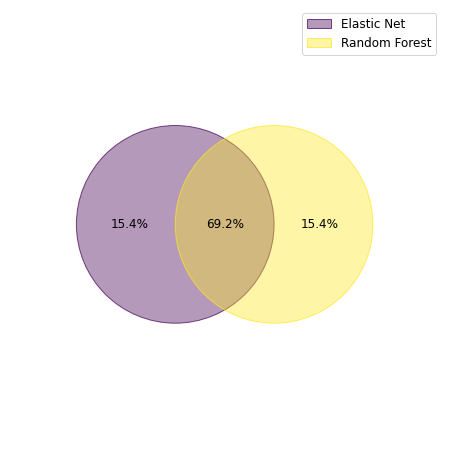

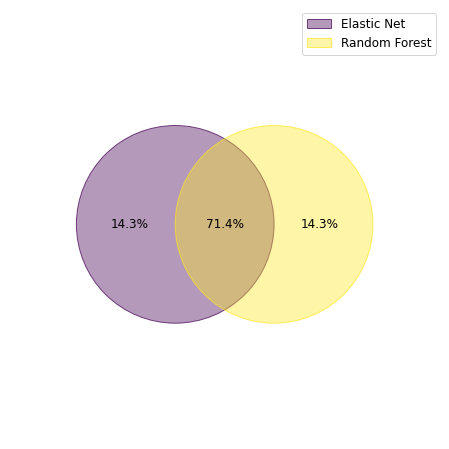

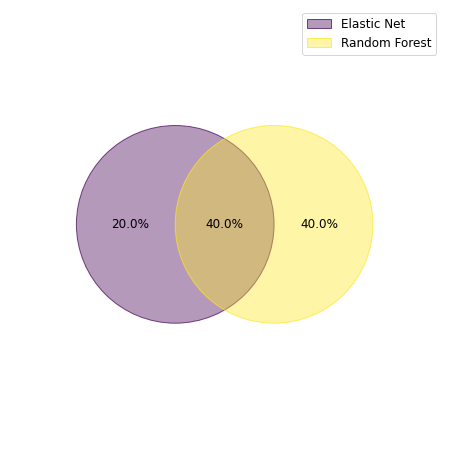

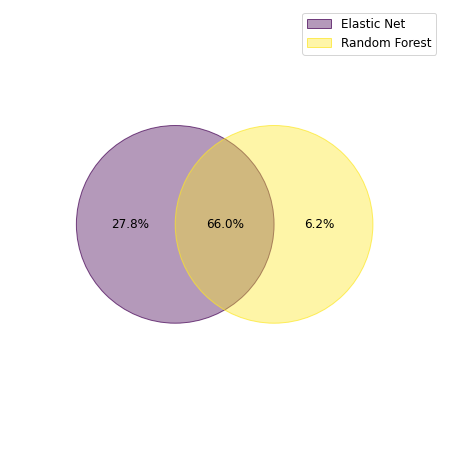

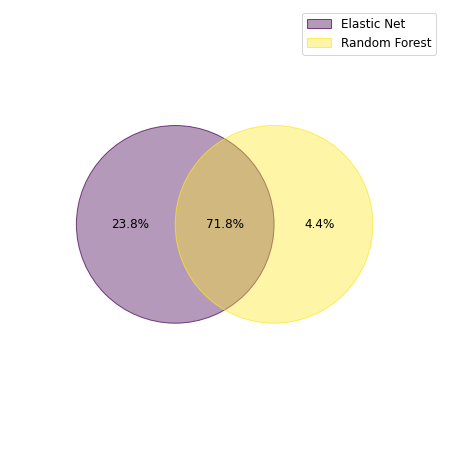

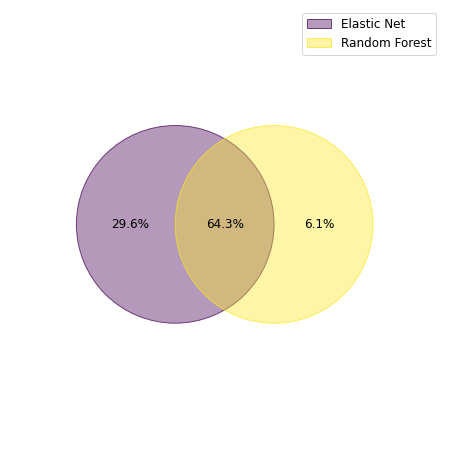

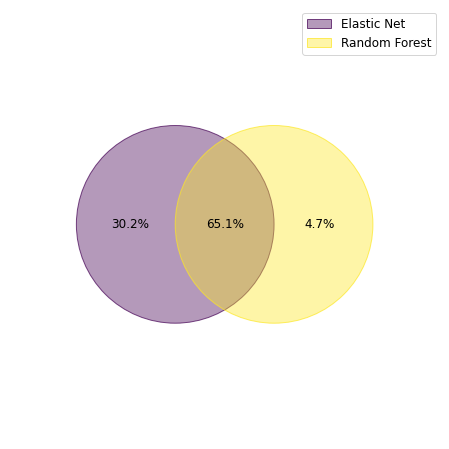

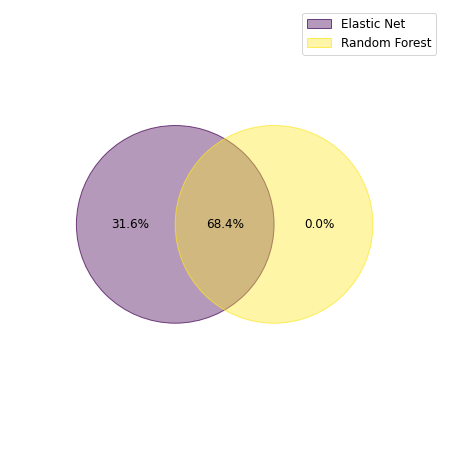

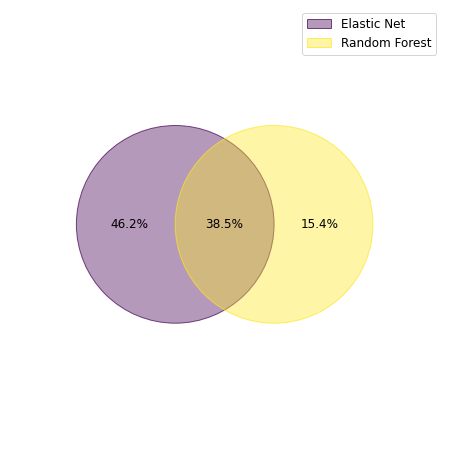

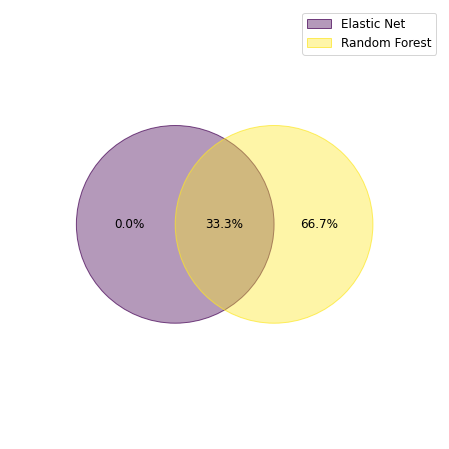

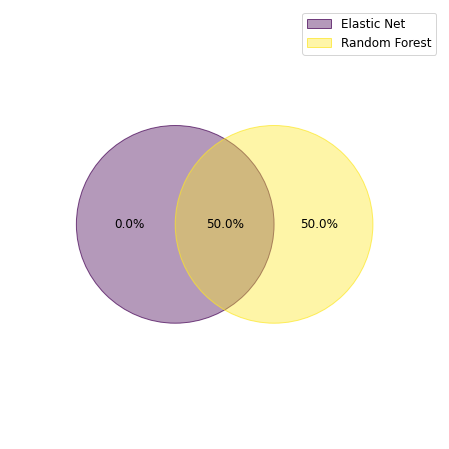

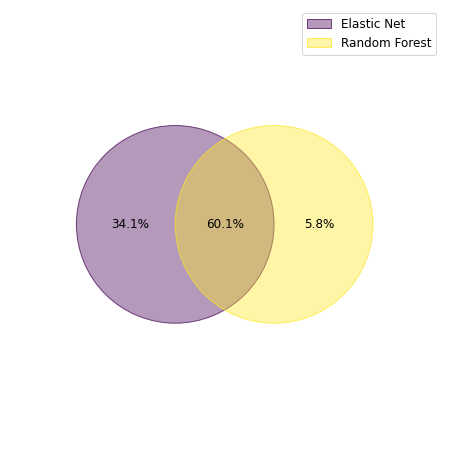

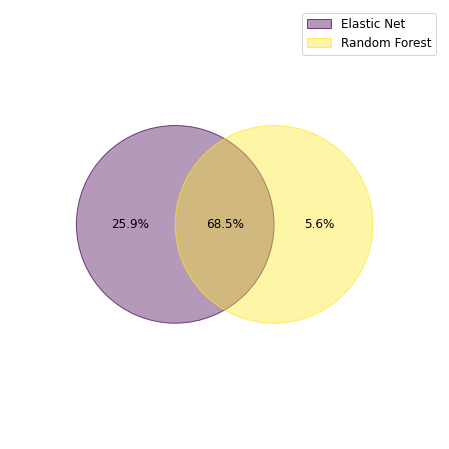

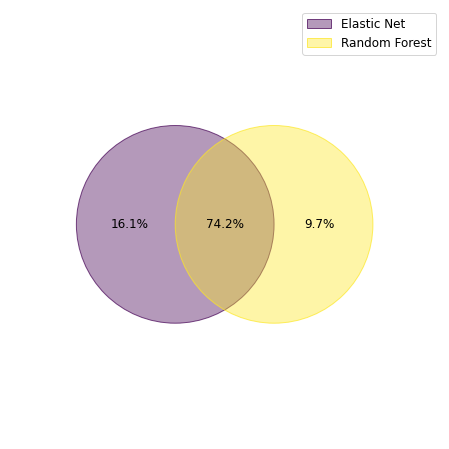

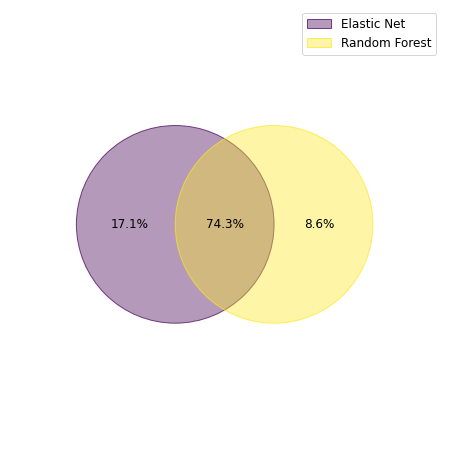

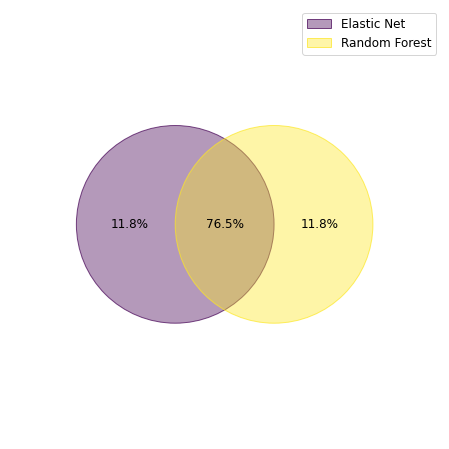

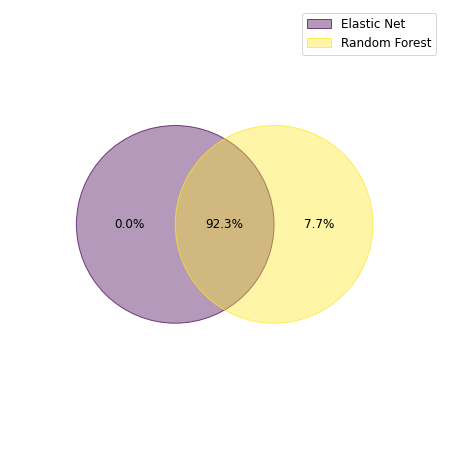

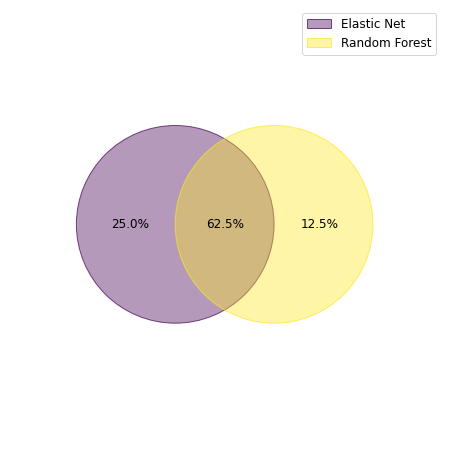

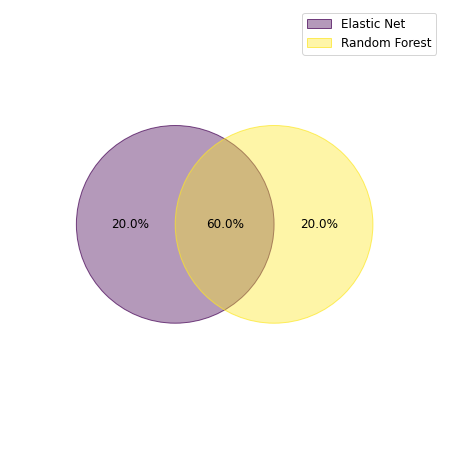

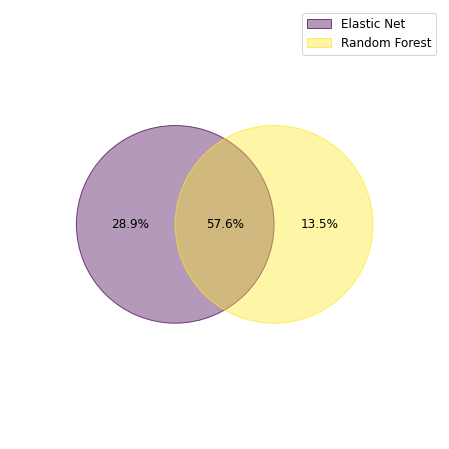

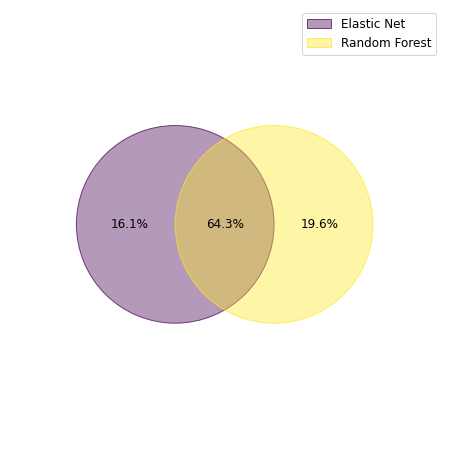

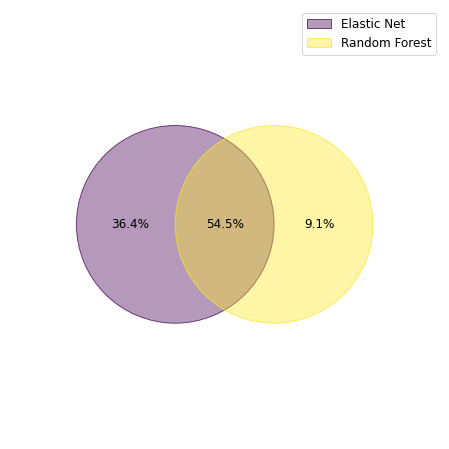

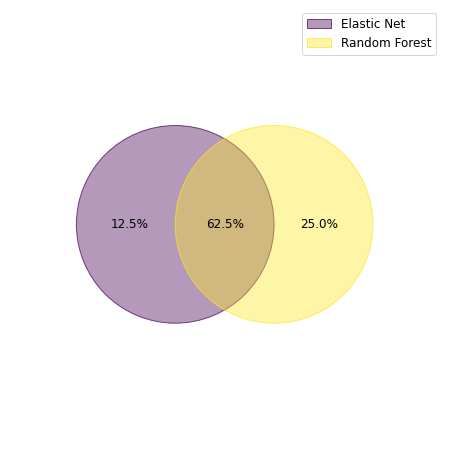

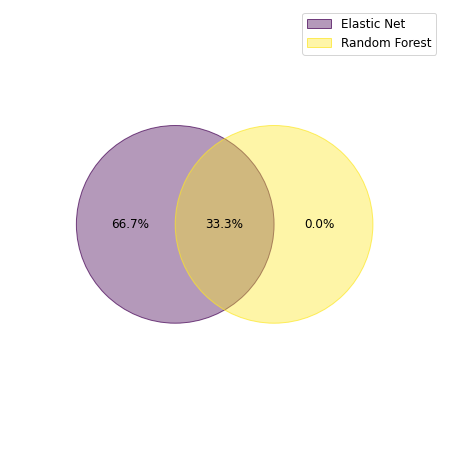

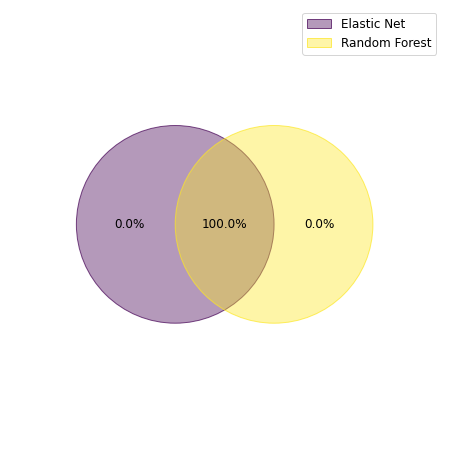

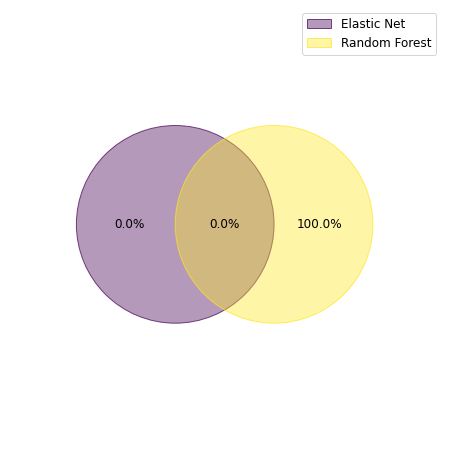

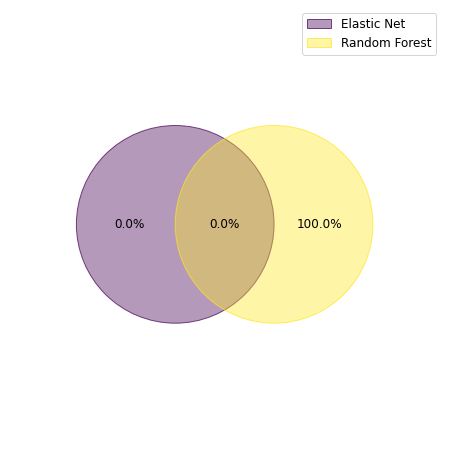

In [24]:
dirname = "model_venn_diagrams"
mkdir_p(dirname)
for tissue in ["Caudate", "DLPFC", "Hippocampus", "Dentate Gyrus"]:
    #print(tissue)
    for r2 in [0, 0.2, 0.5, 0.6, 0.7, 0.75, 0.8]:
        ee = enet[(enet["tissue"] == tissue) & (enet["test_score_r2"] >= r2)].copy()
        rr = rf[(rf["tissue"] == tissue) & (rf["test_score_r2"] >= r2)].copy()
        model_set = {"Elastic Net": set(ee.feature), "Random Forest": set(rr.feature),}
        venn(model_set, fmt="{percentage:.1f}%", fontsize=12)
        tt = tissue.lower().replace(" ", "_")
        plt.savefig("{}/venn_diagram_modelOverlap_{}_r2_{}.png".format(dirname, tt, r2))
        plt.savefig("{}/venn_diagram_modelOverlap_{}_r2_{}.pdf".format(dirname, tt, r2))
        plt.savefig("{}/venn_diagram_modelOverlap_{}_r2_{}.svg".format(dirname, tt, r2))

### What is the overlap between brain regions?

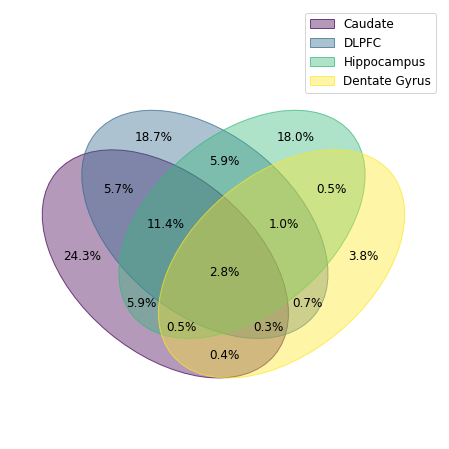

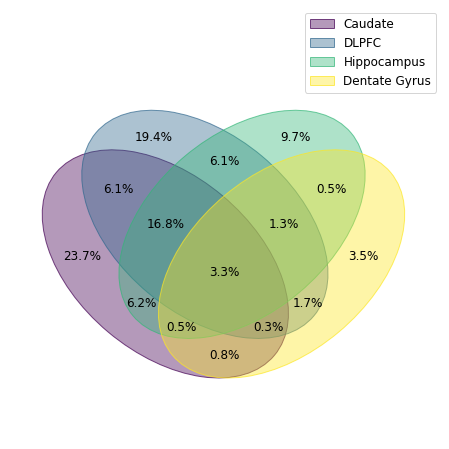

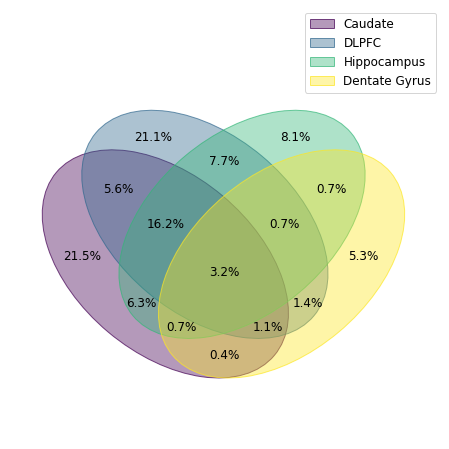

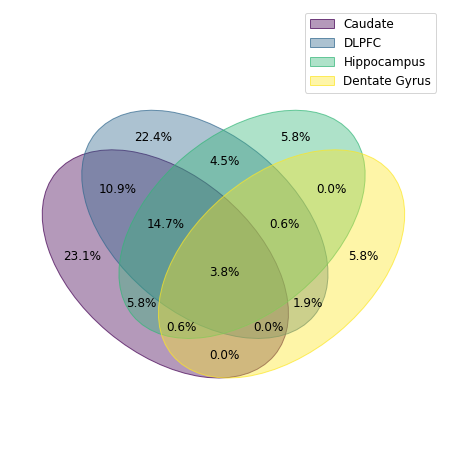

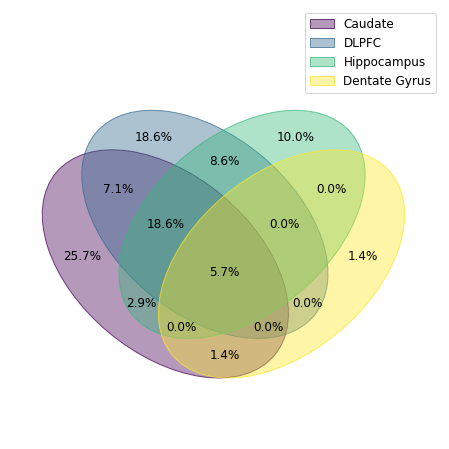

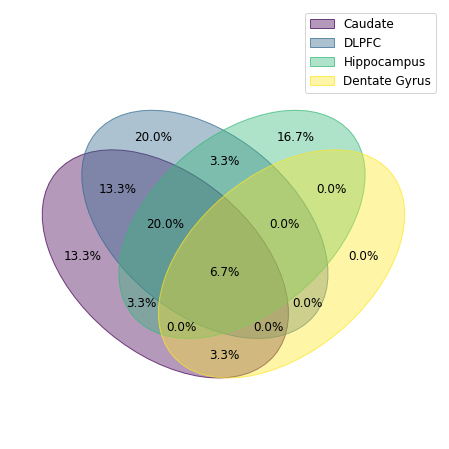

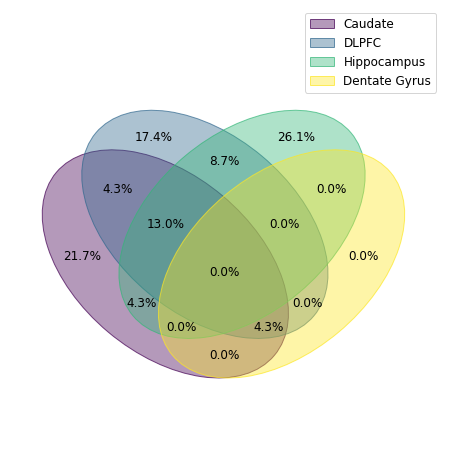

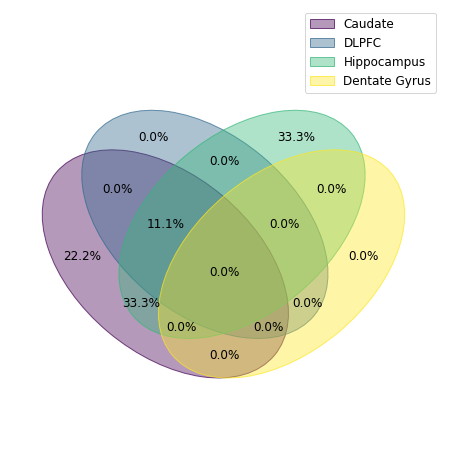

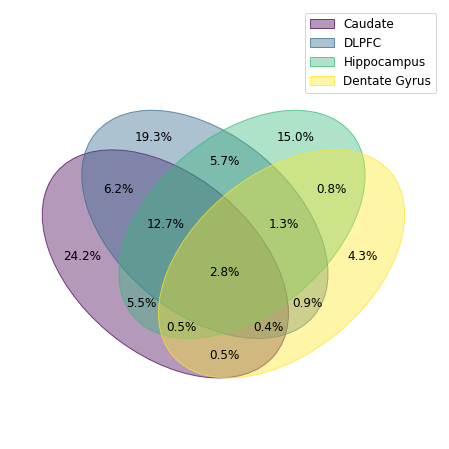

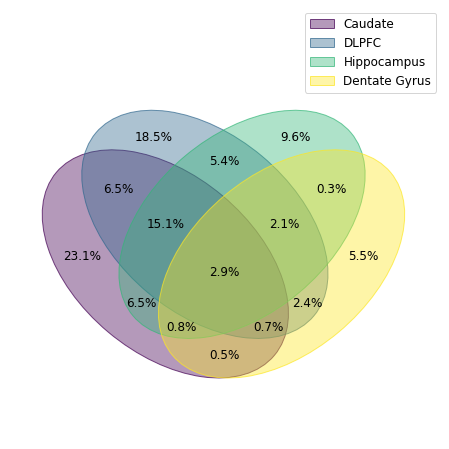

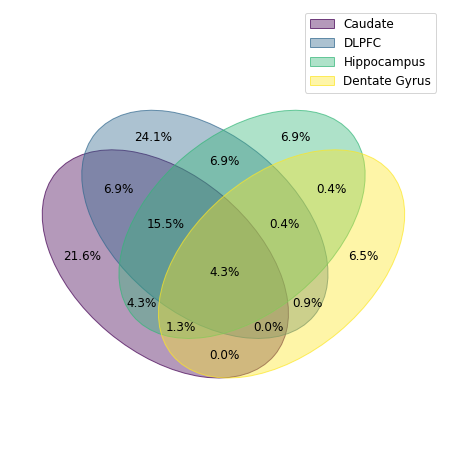

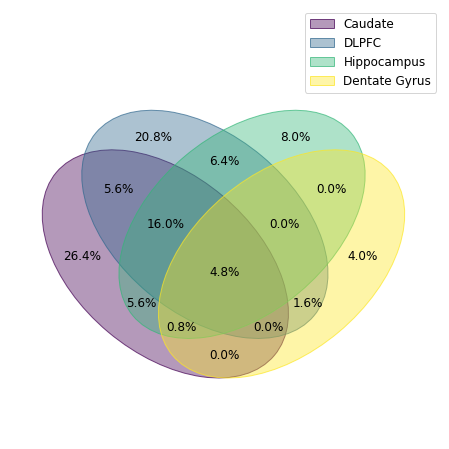

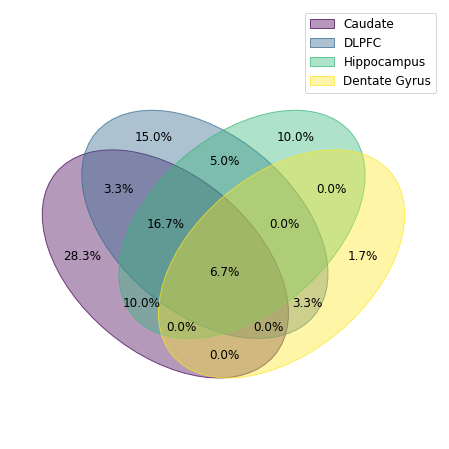

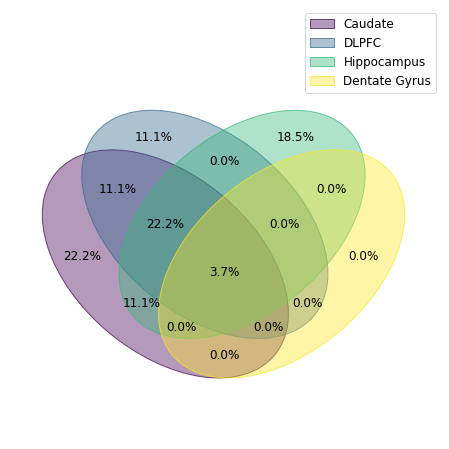

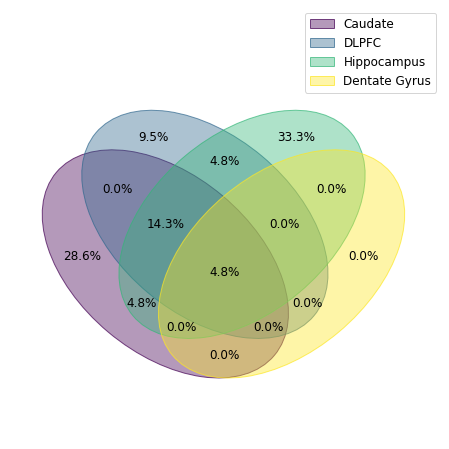

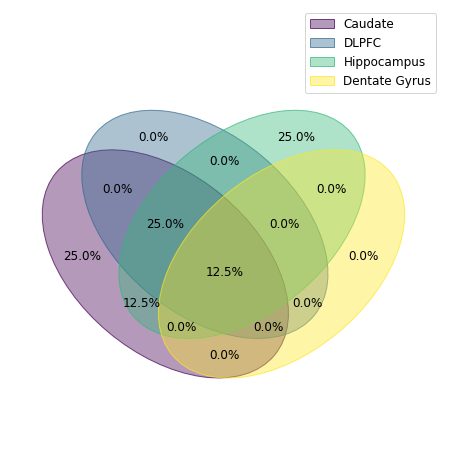

In [23]:
dirname = "tissue_venn_diagrams"
mkdir_p(dirname)
for modeln in ["Elastic Net", "Random Forest"]:
    #print(modeln)
    dft = df[(df['Model'] == modeln)].copy()
    for r2 in [0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8]:
        cc = dft[(dft["tissue"] == "Caudate") & (dft["test_score_r2"] >= r2)].copy()
        dd = dft[(dft["tissue"] == "DLPFC") & (dft["test_score_r2"] >= r2)].copy()
        hh = dft[(dft["tissue"] == "Hippocampus") & (dft["test_score_r2"] >= r2)].copy()
        gg = dft[(dft["tissue"] == "Dentate Gyrus") & (dft["test_score_r2"] >= r2)].copy()
        tissues = {"Caudate": set(cc.feature), "DLPFC": set(dd.feature), 
                   "Hippocampus": set(hh.feature), "Dentate Gyrus": set(gg.feature)}
        venn(tissues, fmt="{percentage:.1f}%", fontsize=12)
        mm = modeln.lower().replace(" ", "_")
        plt.savefig("{}/venn_diagram_tissueOverlap_{}_r2_{}.png".format(dirname, mm, r2))
        plt.savefig("{}/venn_diagram_tissueOverlap_{}_r2_{}.pdf".format(dirname, mm, r2))
        plt.savefig("{}/venn_diagram_tissueOverlap_{}_r2_{}.svg".format(dirname, mm, r2))

## Examining partial R2 results using most predictive SNPs

In [41]:
partial.groupby("tissue").describe().T

tissue                   Caudate        DLPFC  Dentate Gyrus  Hippocampus
n_features    count  2867.000000  2660.000000     770.000000  2843.000000
              mean     12.514126    13.332331      14.385714    11.902919
              std      23.181572    27.876792      19.540510    22.613318
              min       1.000000     1.000000       1.000000     1.000000
              25%       3.000000     3.000000       4.000000     2.000000
              50%       4.000000     5.000000       8.000000     4.000000
              75%      13.000000    15.000000      15.750000    12.000000
              max     433.000000   915.000000     199.000000   347.000000
test_score_r2 count  2867.000000  2660.000000     770.000000  2843.000000
              mean      0.121152     0.129189       0.201115     0.103866
              std       0.149158     0.154981       0.185990     0.142715
              min       0.000000     0.000000       0.000000     0.000000
              25%       0.014847     0.019266       0.055788     0.010154
              50%       0.064597     0.070831       0.144500     0.047870
              75%       0.169860     0.185071       0.281533     0.136068
              max       0.890767     0.914657       1.000000     0.921536

In [42]:
partial[(partial["test_score_r2"] > 0.88)]

,tissue,feature,n_features,test_score_r2,Model
1288,Caudate,ENSG00000166435.15,25,0.890767,Partial R2
5210,DLPFC,ENSG00000257218.5,149,0.907953,Partial R2
5501,DLPFC,ENSG00000279672.1,146,0.914657,Partial R2
5565,Hippocampus,ENSG00000013573.16,9,0.880784,Partial R2
5996,Hippocampus,ENSG00000111788.10,84,0.882758,Partial R2
7888,Hippocampus,ENSG00000244879.5,166,0.908674,Partial R2
7996,Hippocampus,ENSG00000255374.3,74,0.921536,Partial R2
8392,Dentate Gyrus,ENSG00000065325.12,95,1.000000,Partial R2


- *GLP2R* (ENSG00000065325) Glucagon Like Peptide 2 Receptor

In [43]:
idv_partial = pd.read_csv("../../partial_r2/individual_partial_r2_metrics.tsv", sep='\t')
idv_partial.head(2)

,SNP,Partial_R2,Full_R2,Reduced_R2,Tissue,Geneid
0,chrX_30633576_C_T_0,0.000065,227.834700,227.849408,Caudate,ENSG00000198814.12
1,chrX_30633576_C_T_1,0.008910,225.819164,227.849408,Caudate,ENSG00000198814.12


In [48]:
idv_partial[["Partial_R2", "Tissue", "Geneid"]].groupby("Tissue").describe().T

Tissue                 Caudate         DLPFC  Dentate Gyrus   Hippocampus
Partial_R2 count  1.762851e+06  1.595825e+06  450379.000000  1.720189e+06
           mean   1.177298e-02  1.192422e-02       0.017215  1.016017e-02
           std    3.623054e-02  3.529084e-02       0.042975  3.167019e-02
           min    0.000000e+00  0.000000e+00       0.000000  0.000000e+00
           25%    0.000000e+00  0.000000e+00       0.000000  0.000000e+00
           50%    1.151334e-03  1.190616e-03       0.001776  1.026979e-03
           75%    8.549333e-03  8.895461e-03       0.016113  7.504191e-03
           max    8.853651e-01  9.086128e-01       0.927805  8.921231e-01

#### The vast majority of SNPs to not hold a lot of information (partial r2 < 0.01) with 25% close to 0.

In [53]:
idv_partial.loc[(idv_partial["Partial_R2"] >= 0.8), ["Tissue", "Partial_R2", "Geneid"]].groupby("Tissue").size()

Tissue
Caudate          129
DLPFC             25
Dentate Gyrus     29
Hippocampus       78
dtype: int64

In [54]:
idv_partial.loc[(idv_partial["Partial_R2"] >= 0.8), ["Tissue", "Partial_R2", "Geneid"]].groupby("Geneid").size()

Geneid
ENSG00000013573.16    93
ENSG00000074803.17     3
ENSG00000142856.16    19
ENSG00000164346.9     17
ENSG00000166435.15    12
ENSG00000228906.1     27
ENSG00000255374.3     58
ENSG00000256274.1      3
ENSG00000267370.1      3
ENSG00000270605.1     26
dtype: int64

In [56]:
idv_partial.loc[(idv_partial["Partial_R2"] >= 0.8), ["Tissue", "Partial_R2", "Geneid"]].groupby(["Geneid", "Tissue"]).size()

Geneid              Tissue       
ENSG00000013573.16  Caudate          93
ENSG00000074803.17  DLPFC             3
ENSG00000142856.16  Caudate           7
                    DLPFC             7
                    Hippocampus       5
ENSG00000164346.9   Caudate          17
ENSG00000166435.15  Caudate           3
                    DLPFC             3
                    Dentate Gyrus     3
                    Hippocampus       3
ENSG00000228906.1   Caudate           9
                    DLPFC             9
                    Hippocampus       9
ENSG00000255374.3   Hippocampus      58
ENSG00000256274.1   Hippocampus       3
ENSG00000267370.1   DLPFC             3
ENSG00000270605.1   Dentate Gyrus    26
dtype: int64